# Spatial UNSEEN analysis

This notebook performs a spatial analysis of a climate hazard using the UNprecedented Simulated Extremes using ENsembles (UNSEEN) method for the Australian Climate Service (ACS). 

The UNSEEN method uses model ensembles to generate large samples of plausible events to estimate the likelihood of extreme events. 


## Notes

- The notebook displays the output of a single model and a single climate metric.
- This notebook is setup to be run using papermill, which allow the user to specify parameters that will be imported into the notebook (in a new cell after tagged parameters).
- The cell tagged as parameters contains default parameters that can be overwritten by the user.
- Uncorrected and/or additive/multiplicative bias corrected versions of most plots are generated.
- Some of the output plot files names are defined as input arguments (namely the independence and similarity plots), while the majority are generated in the spatial_plots functions (the model forecast filename stem is appended to the plot filename and saved in the user defined figure directory).

## Prerequisites

- There are a number of prerequisite data files including the climate metric (observations and model), independence and similarity test results and nonstationary GEV parameters. 
- Requires local copies of [spatial_plots.py](https://github.com/AusClimateService/unseen-projects/blob/master/spatial_plots.py) and [plotting_maps](https://github.com/AusClimateService/plotting_maps) ([this fork updated to allow norm kwarg](https://github.com/stellema/plotting_maps)). 
    - To avoid errors importing the local modules, either:
        - Add the paths to your conda environment using: conda develop /path/to/plotting_maps and conda develop /path/to/unseen-projects/code
        - Run (or add to your ~/.bashrc): export PYTHONPATH="/path/to/module/:$PYTHONPATH"

In [1]:
"""
Parameters
----------
metric : str
    Metric to analyse (e.g. "txx", "tnn", "rx1day")
var : str
    Variable name of the metric in the dataset
model_name : str
    Name of the model
obs_name : str
    Name of the observational dataset for plot labels
time_agg : {"maximum", "minimum"}, default="maximum"
    The method for aggregating the time dimension of the metric to examine extremes (e.g., "maximum" for TXx or Rx5day and "minimum" for TNn)
plot_dict : dict or str
    Dictionary of metric plot labels, ticks and colormaps with keys:
        'metric' (e.g., 'TXx'), 'var', 'var_name', 'units', 'units_label', 'freq', 'obs_name', 'cmap', 'cmap_anom', 'ticks', 'ticks_anom', 'ticks_param_trend', 'cbar_extend', 'agcd_mask', etc
fig_dir : str
    Directory to save the figures
reference_time_period : str, optional
    Reference time period for the metric in observations (e.g., "1961-06-30 2023-06-30")
min_lead_spatial_agg : {None, "mean", "median", "max"}
    Spatial aggregation for determining the minimum independent lead time
shapefile : str, optional
    Path to shapefile for used if the the minimum independent lead time is based on spatial aggregation, rather than grid point specific
shape_overlap : float, optional
    Minimum overlap between shapefile and grid cell (see `shapefile` parameter)
similarity_test : {"ks", "ad"}, default="ks"
    Statistical test testing the similarity between model and observations
alpha : float, default=0.05
    Significance level for similarity test
covariate_base : int
    Base year to substitute in the non-stationary GEV model (i.e., the year for which AEP is relative to)
gev_trend_period : str or list
    Start and end year for determining the trend in the AEP (e.g., '[1961, 2025]')
plot_additive_bc : bool, default=True
    Plot the bias-corrected model data using an additive bias correction. If True, then then all associated prerequisite files must be provided. Note that the similarity test plots will still be plotted if the data file is available
plot_multiplicative_bc : bool, default=False
    Plot the multiplicative bias-corrected model data
obs_file : str
    Filename of the metric based on observations
model_file : str
    Filename of metric from the model
model_mulc_bc_file : str, optional
    Filename of the additive bias-corrected metric
model_mulc_bc_file : str, optional
    Filename of the multiplicative bias-corrected metric
independence_file : str
    PFilename of the independence test file
independence_plot : str
    Filename for the minimum independent lead time plot
similarity_raw_file : str
    Filename of the similarity test file based on uncorrected model data
similarity_mulc_bc_file : str, optional
    Filename of the similarity test file based on additive bias-corrected model data
similarity_mulc_bc_file : str, optional
    Filename of the similarity test file based on multiplicative bias-corrected model data
similarity_raw_plot : str
    Filename of the similarity test plot based on uncorrected model data
similarity_add_bc_plot : str, optional
    Filename of the similarity test plot based on additive bias-corrected model data
similarity_mulc_bc_plot : str, optional
    Filename of the similarity test plot based on multiplicative bias-corrected model data
gev_params_nonstationary_file : str
    Filename of the model non-stationary GEV parameters
gev_params_nonstationary_add_bc_file : str, optional
    Filename of the additive bias-corrected model non-stationary GEV parameters
gev_params_nonstationary_mulc_bc_file : str, optional
    Filename of the multiplicative bias-corrected model non-stationary GEV parameters
"""

'\nParameters\n----------\nmetric : str\n    Metric to analyse (e.g. "txx", "tnn", "rx1day")\nvar : str\n    Variable name of the metric in the dataset\nmodel_name : str\n    Name of the model\nobs_name : str\n    Name of the observational dataset for plot labels\ntime_agg : {"maximum", "minimum"}, default="maximum"\n    The method for aggregating the time dimension of the metric to examine extremes (e.g., "maximum" for TXx or Rx5day and "minimum" for TNn)\nplot_dict : dict or str\n    Dictionary of metric plot labels, ticks and colormaps with keys:\n        \'metric\' (e.g., \'TXx\'), \'var\', \'var_name\', \'units\', \'units_label\', \'freq\', \'obs_name\', \'cmap\', \'cmap_anom\', \'ticks\', \'ticks_anom\', \'ticks_param_trend\', \'cbar_extend\', \'agcd_mask\', etc\nfig_dir : str\n    Directory to save the figures\nreference_time_period : str, optional\n    Reference time period for the metric in observations (e.g., "1961-06-30 2023-06-30")\nmin_lead_spatial_agg : {None, "mean", "me

In [2]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LatitudeFormatter, LongitudeFormatter
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
import os
from pathlib import Path
import xarray as xr

from unseen import fileio, independence, similarity, eva, time_utils, spatial_selection
from acs_plotting_maps import cmap_dict, tick_dict, regions_dict  # NOQA
import spatial_plots

In [3]:
# Optional parameters
alpha = 0.05
ensemble_dim = "ensemble"
init_dim = "init_date"
lead_dim = "lead_time"
time_dim = "time"
lat_dim = "lat"
lon_dim = "lon"
similarity_test = "ks"
time_agg = "maximum"
plot_additive_bc = True
plot_multiplicative_bc = True
reference_time_period = None

In [4]:
# Parameters
model_name = "EC-Earth3"
metric = "rx1day"
var = "pr"
obs_name = "AGCD-CSIRO"
reference_time_period = "1961-06-30 2023-06-30"
time_agg = "maximum"
covariate_base = 2025
gev_trend_period = "[1961, 2025]"
plot_dict = "dict(metric=\"Rx1day\", var=\"pr\", var_name=\"Precipitation\", units=\"mm day-1\", units_label=\"Precipitation [mm day-1]\", freq=\"YE-SEP\", cmap=cmap_dict[\"pr\"], cmap_anom=cmap_dict[\"pr_anom\"], ticks=np.arange(0, 280, 25), ticks_anom=np.arange(-110, 110 + 20, 20), ticks_anom_std=np.arange(-22.5, 22.5 + 5, 5), ticks_anom_pct=np.arange(-110, 110 + 20, 20), ticks_anom_ratio=np.arange(-0.1, 2.1 + 3, 0.2), ticks_trend=np.arange(-50, 60, 10), ticks_param_trend={\"location\": np.arange(-2, 2.5, 0.5), \"scale\": np.arange(-0.5, 0.51, 0.1)}, cbar_extend=\"max\", agcd_mask=True)"
fig_dir = "/g/data/xv83/unseen-projects/outputs/rx1day/figures"
plot_additive_bc = 0
plot_multiplicative_bc = 1
shapefile = "/g/data/xv83/unseen-projects/outputs/rx1day/shapefiles/australia.shp"
shape_overlap = 0.1
obs_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/rx1day_AGCD-CSIRO_r05_1901-2024_annual-oct-to-sep_aus.nc"
model_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/rx1day_EC-Earth3-dcppA-hindcast_196011-201711_annual-oct-to-sep_aus.nc"
model_add_bc_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/rx1day_EC-Earth3-dcppA-hindcast_196011-201711_annual-oct-to-sep_aus_bias-corrected-AGCD-CSIRO_r05-additive.nc"
model_mulc_bc_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/rx1day_EC-Earth3-dcppA-hindcast_196011-201711_annual-oct-to-sep_aus_bias-corrected-AGCD-CSIRO_r05-multiplicative.nc"
independence_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/independence-test_rx1day_EC-Earth3-dcppA-hindcast_196011-201711_annual-oct-to-sep_aus.nc"
independence_plot = "/g/data/xv83/unseen-projects/outputs/rx1day/figures/independence-test_rx1day_EC-Earth3-dcppA-hindcast_196011-201711_annual-oct-to-sep_aus.png"
min_lead_spatial_agg = "median"
similarity_raw_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/similarity-test_rx1day_EC-Earth3-dcppA-hindcast_1970-2017_annual-oct-to-sep_aus_AGCD-CSIRO_r05.nc"
similarity_add_bc_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/similarity-test_rx1day_EC-Earth3-dcppA-hindcast_1970-2017_annual-oct-to-sep_aus_bias-corrected-AGCD-CSIRO_r05-additive.nc"
similarity_mulc_bc_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/similarity-test_rx1day_EC-Earth3-dcppA-hindcast_1970-2017_annual-oct-to-sep_aus_bias-corrected-AGCD-CSIRO_r05-multiplicative.nc"
similarity_raw_plot = "/g/data/xv83/unseen-projects/outputs/rx1day/figures/similarity-test_rx1day_EC-Earth3-dcppA-hindcast_1970-2017_annual-oct-to-sep_aus_AGCD-CSIRO_r05.png"
similarity_add_bc_plot = "/g/data/xv83/unseen-projects/outputs/rx1day/figures/similarity-test_rx1day_EC-Earth3-dcppA-hindcast_1970-2017_annual-oct-to-sep_aus_bias-corrected-AGCD-CSIRO_r05-additive.png"
similarity_mulc_bc_plot = "/g/data/xv83/unseen-projects/outputs/rx1day/figures/similarity-test_rx1day_EC-Earth3-dcppA-hindcast_1970-2017_annual-oct-to-sep_aus_bias-corrected-AGCD-CSIRO_r05-multiplicative.png"
gev_params_nonstationary_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/gev_params_nonstationary_rx1day_EC-Earth3-dcppA-hindcast_196011-201711_annual-oct-to-sep_aus.nc"
gev_params_nonstationary_add_bc_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/gev_params_nonstationary_rx1day_EC-Earth3-dcppA-hindcast_196011-201711_annual-oct-to-sep_aus_bias-corrected-AGCD-CSIRO_r05-additive.nc"
gev_params_nonstationary_mulc_bc_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/gev_params_nonstationary_rx1day_EC-Earth3-dcppA-hindcast_196011-201711_annual-oct-to-sep_aus_bias-corrected-AGCD-CSIRO_r05-multiplicative.nc"
gev_params_stationary_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/gev_params_stationary_rx1day_EC-Earth3-dcppA-hindcast_196011-201711_annual-oct-to-sep_aus.nc"
gev_params_stationary_add_bc_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/gev_params_stationary_rx1day_EC-Earth3-dcppA-hindcast_196011-201711_annual-oct-to-sep_aus_bias-corrected-AGCD-CSIRO_r05-additive.nc"
gev_params_stationary_mulc_bc_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/gev_params_stationary_rx1day_EC-Earth3-dcppA-hindcast_196011-201711_annual-oct-to-sep_aus_bias-corrected-AGCD-CSIRO_r05-multiplicative.nc"
gev_params_best_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/gev_params_nonstationary_bic_rx1day_EC-Earth3-dcppA-hindcast_196011-201711_annual-oct-to-sep_aus.nc"
gev_params_best_add_bc_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/gev_params_nonstationary_bic_rx1day_EC-Earth3-dcppA-hindcast_196011-201711_annual-oct-to-sep_aus_bias-corrected-AGCD-CSIRO_r05-additive.nc"
gev_params_best_mulc_bc_file = "/g/data/xv83/unseen-projects/outputs/rx1day/data/gev_params_nonstationary_bic_rx1day_EC-Earth3-dcppA-hindcast_196011-201711_annual-oct-to-sep_aus_bias-corrected-AGCD-CSIRO_r05-multiplicative.nc"


In [5]:
# Required parameters
kwargs = locals()
assert "metric" in kwargs, "Must provide a metric name"
assert "var" in kwargs, "Must provide a variable name"
assert "model_name" in kwargs, "Must provide a model name"

if isinstance(reference_time_period, str):
    reference_time_period = list(reference_time_period.split(" "))
assert (
    "covariate_base" in kwargs
), "Must provide a nonstationary GEV covariate base year"
assert (
    time_agg in spatial_plots.func_dict
), f"Invalid time aggregation method: {time_agg} (options: {list(spatial_plots.func_dict.keys())})"

# Format parameters passed as strings
assert (
    "gev_trend_period" in kwargs
), "Must provide a GEV trend period (e.g., '[1981, 2010]')"
if isinstance(gev_trend_period, str):
    # Convert string to list
    gev_trend_period = eval(gev_trend_period)
    print(f"gev_trend_period: {gev_trend_period}")

assert (
    "plot_dict" in kwargs
), "Must provide spatial plot dictionary of labels, ticks and colormaps"
if isinstance(plot_dict, str):
    # Convert string to dictionary and check for required keys
    plot_dict = eval(plot_dict)

    for key in [
        "metric",
        "var",
        "var_name",
        "units",
        "units_label",
        "freq",
        "cmap",
        "cmap_anom",
        "ticks",
        "ticks_anom",
        "ticks_anom_std",
        "ticks_anom_pct",
        "ticks_anom_ratio",
        "ticks_trend",
        "ticks_param_trend",
        "cbar_extend",
        "agcd_mask",
    ]:
        assert key in plot_dict, f"Missing key: {key} in plot_dict"
    plot_dict["agcd_mask"] = False  # AGCD data/grid only

assert os.path.isfile(
    obs_file
), f"Must provide an observations data file (papermill option -p obs_file [filepath])"
assert os.path.isfile(
    model_file
), "Must provide an model data file (papermill option -p model_file [filepath])"
assert os.path.isfile(
    independence_file
), "Must provide an independence min lead file (papermill option -p independence_file [filepath])"
assert os.path.isfile(
    similarity_raw_file
), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(
    gev_params_nonstationary_file
), "Must provide a non-stationary GEV parameter file (papermill option -p gev_params_nonstationary_file [filepath])"

# Required bias corrected files
if plot_additive_bc:
    assert os.path.isfile(
        similarity_add_bc_file
    ), "Must provide an additive bias corrected similarity test file (papermill option -p similarity_add_bias_file [filepath])"
    assert os.path.isfile(
        model_add_bc_file
    ), "Must provide a model additive bias corrected data file (papermill option -p model_add_bc_file [filepath])"
    assert os.path.isfile(gev_params_nonstationary_add_bc_file)

if plot_multiplicative_bc:
    assert os.path.isfile(
        similarity_mulc_bc_file
    ), "Must provide an multiplicative bias corrected similarity test file (papermill option -p similarity_mulc_bias_file [filepath])"
    assert os.path.isfile(
        model_mulc_bc_file
    ), "Must provide a model multiplicative bias corrected data file (papermill option -p model_mulc_bc_file [filepath])"
    assert os.path.isfile(gev_params_nonstationary_mulc_bc_file)

gev_trend_period: [1961, 2025]


In [6]:
fig_dir = f"{fig_dir}/acs/"

## Model data


In [7]:
model_ds = fileio.open_dataset(model_file)
model_ds

<xarray.Dataset> Size: 1GB
Dimensions:     (init_date: 58, ensemble: 15, lead_time: 9, lat: 57, lon: 67)
Coordinates:
    event_time  (init_date, ensemble, lead_time, lat, lon) <U10 1GB dask.array<chunksize=(58, 15, 9, 57, 67), meta=np.ndarray>
  * lon         (lon) float64 536B 110.4 111.1 111.8 112.5 ... 155.4 156.1 156.8
  * lat         (lat) float64 456B -45.97 -45.26 -44.56 ... -8.07 -7.368 -6.667
  * ensemble    (ensemble) int64 120B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * lead_time   (lead_time) int64 72B 0 1 2 3 4 5 6 7 8
  * init_date   (init_date) object 464B 1962-11-01 00:00:00 ... 2019-11-01 00...
    time        (lead_time, init_date) object 4kB dask.array<chunksize=(9, 58), meta=np.ndarray>
Data variables:
    pr          (init_date, ensemble, lead_time, lat, lon) float32 120MB dask.array<chunksize=(58, 15, 9, 57, 67), meta=np.ndarray>
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               DCPP
    branch_method:             no parent
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    variant_info:              Atmosphere initialization based on full-fields...
    nominal_resolution:        100 km
    sub_experiment:            initialized near end of year 1960
    sub_experiment_id:         s1960
    history:                   Thu Apr 17 12:44:44 2025: /g/data/xv83/as3189/...
    NCO:                       netCDF Operators version 4.9.2 (Homepage = htt...

In [8]:
# Convert event_time date strings to datetime or cftime
try:
    event_times = np.vectorize(time_utils.str_to_cftime)(
        model_ds.event_time, model_ds.time.dt.calendar
    )
    model_ds["event_time"] = (model_ds.event_time.dims, event_times)
except ValueError:
    model_ds["event_time"] = model_ds.event_time.astype(
        dtype="datetime64[ns]"
    ).compute()
model_ds

<xarray.Dataset> Size: 359MB
Dimensions:     (init_date: 58, ensemble: 15, lead_time: 9, lat: 57, lon: 67)
Coordinates:
    event_time  (init_date, ensemble, lead_time, lat, lon) object 239MB 1962-...
  * lon         (lon) float64 536B 110.4 111.1 111.8 112.5 ... 155.4 156.1 156.8
  * lat         (lat) float64 456B -45.97 -45.26 -44.56 ... -8.07 -7.368 -6.667
  * ensemble    (ensemble) int64 120B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * lead_time   (lead_time) int64 72B 0 1 2 3 4 5 6 7 8
  * init_date   (init_date) object 464B 1962-11-01 00:00:00 ... 2019-11-01 00...
    time        (lead_time, init_date) object 4kB dask.array<chunksize=(9, 58), meta=np.ndarray>
Data variables:
    pr          (init_date, ensemble, lead_time, lat, lon) float32 120MB dask.array<chunksize=(58, 15, 9, 57, 67), meta=np.ndarray>
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               DCPP
    branch_method:             no parent
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    variant_info:              Atmosphere initialization based on full-fields...
    nominal_resolution:        100 km
    sub_experiment:            initialized near end of year 1960
    sub_experiment_id:         s1960
    history:                   Thu Apr 17 12:44:44 2025: /g/data/xv83/as3189/...
    NCO:                       netCDF Operators version 4.9.2 (Homepage = htt...

In [9]:
if plot_additive_bc:
    model_add_bc_ds = fileio.open_dataset(model_add_bc_file)

    # Convert event_time date strings to cftime
    try:
        event_times = np.vectorize(time_utils.str_to_cftime)(
            model_add_bc_ds.event_time, model_add_bc_ds.time.dt.calendar
        )
        model_add_bc_ds["event_time"] = (model_add_bc_ds.event_time.dims, event_times)
    except ValueError:
        model_add_bc_ds["event_time"] = model_add_bc_ds.event_time.astype(
            dtype="datetime64[ns]"
        ).compute()
    model_add_bc_ds

In [10]:
if plot_multiplicative_bc:
    model_mulc_bc_ds = fileio.open_dataset(model_mulc_bc_file)
    # Convert event_time date strings to cftime
    try:
        event_times = np.vectorize(time_utils.str_to_cftime)(
            model_mulc_bc_ds.event_time, model_mulc_bc_ds.time.dt.calendar
        )
        model_mulc_bc_ds["event_time"] = (model_mulc_bc_ds.event_time.dims, event_times)
    except ValueError:
        model_mulc_bc_ds["event_time"] = model_mulc_bc_ds.event_time.astype(
            dtype="datetime64[ns]"
        ).compute()
    model_mulc_bc_ds

### Independence tests
Perform independence testing to identify which lead times can be considered independent samples. We plot spatial maps of the ensemble mean correlation coefficients for each lead time, the confidence interval bounds and the first lead time in which the correlation is within the bounds.

In [11]:
ds_independence = xr.open_dataset(
    independence_file, decode_times=xr.coders.CFDatetimeCoder(use_cftime=True)
)
ds_independence

<xarray.Dataset> Size: 1GB
Dimensions:     (lon: 67, lat: 57, lead_time: 9, month: 1, quantile: 2,
                 init_date: 58, ensemble: 15)
Coordinates:
  * lon         (lon) float64 536B 110.4 111.1 111.8 112.5 ... 155.4 156.1 156.8
  * lat         (lat) float64 456B -45.97 -45.26 -44.56 ... -8.07 -7.368 -6.667
  * lead_time   (lead_time) int64 72B 0 1 2 3 4 5 6 7 8
  * month       (month) int64 8B 11
  * quantile    (quantile) float64 16B 0.005 0.995
    event_time  (init_date, ensemble, lead_time, lat, lon) <U10 1GB ...
  * ensemble    (ensemble) int64 120B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * init_date   (init_date) object 464B 1962-11-01 00:00:00 ... 2019-11-01 00...
    time        (lead_time, init_date) object 4kB ...
Data variables:
    r           (month, lead_time, lat, lon) float64 275kB ...
    ci          (month, quantile, lat, lon) float64 61kB ...
    min_lead    (month, lat, lon) int64 31kB ...
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               DCPP
    branch_method:             no parent
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    variant_info:              Atmosphere initialization based on full-fields...
    nominal_resolution:        100 km
    sub_experiment:            initialized near end of year 1960
    sub_experiment_id:         s1960
    history:                   Sun Apr 27 19:56:44 2025: /g/data/xv83/as3189/...
    NCO:                       netCDF Operators version 4.9.2 (Homepage = htt...

Correlation coefficients for each initialisation month and lead time

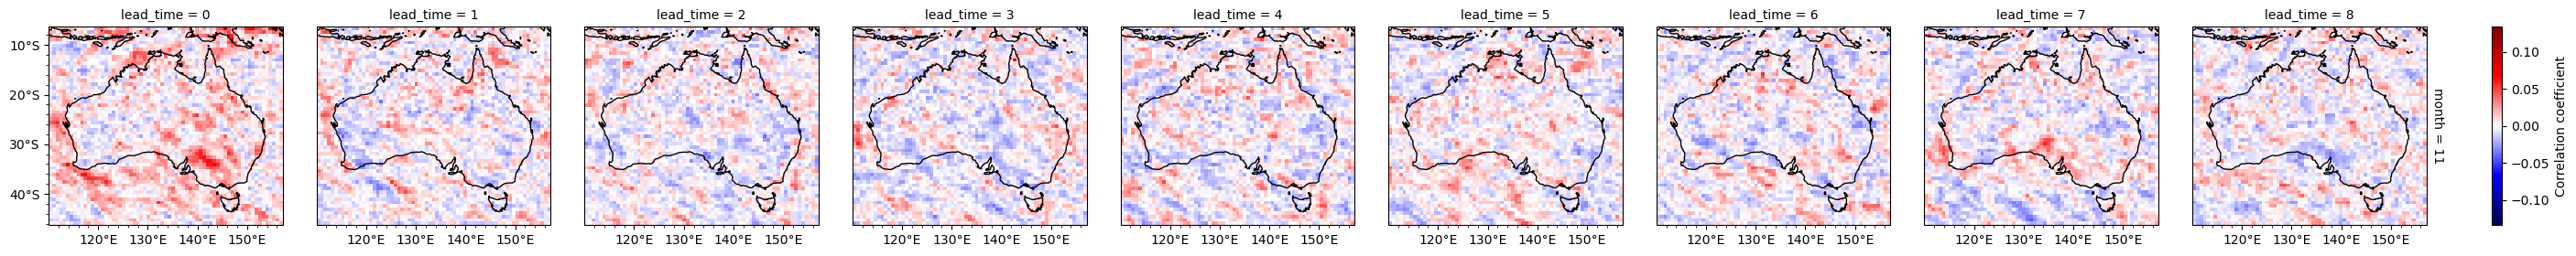

In [12]:
cm = ds_independence.r.plot(
    col=lead_dim,
    row="month",
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    cmap=plt.cm.seismic,
)

# Fix hidden axis ticks and labels
for i, ax in enumerate(cm.axs.flat):
    ax.coastlines()
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    subplotspec = ax.get_subplotspec()
    ax.xaxis.set_visible(True)
    if subplotspec.is_first_col():
        ax.yaxis.set_visible(True)

cm.fig.set_constrained_layout(True)
cm.fig.get_layout_engine().set(h_pad=0.2)
cm.add_colorbar(pad=0.02)

The lower and upper null correlation bounds at each grid point

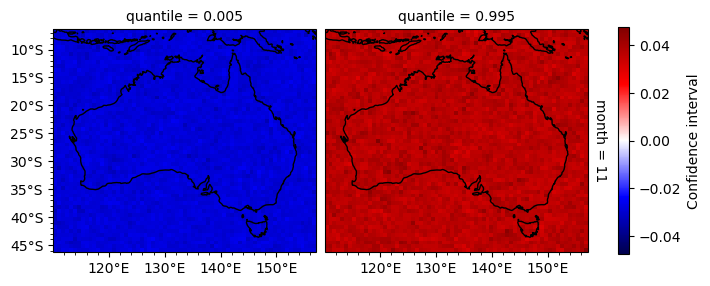

In [13]:
cm = ds_independence.ci.plot(
    col="quantile",
    row="month",
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    cmap=plt.cm.seismic,
)
# Fix hidden axis ticks
for i, ax in enumerate(cm.axs.flat):
    ax.coastlines()
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    subplotspec = ax.get_subplotspec()
    ax.xaxis.set_visible(True)
    if subplotspec.is_first_col():
        ax.yaxis.set_visible(True)

cm.fig.set_constrained_layout(True)
cm.fig.get_layout_engine().set(h_pad=0.2)
cm.add_colorbar(pad=0.02)

Plot map of first independent lead time (first lead time where the correlation coefficient is within the null correlation bounds)

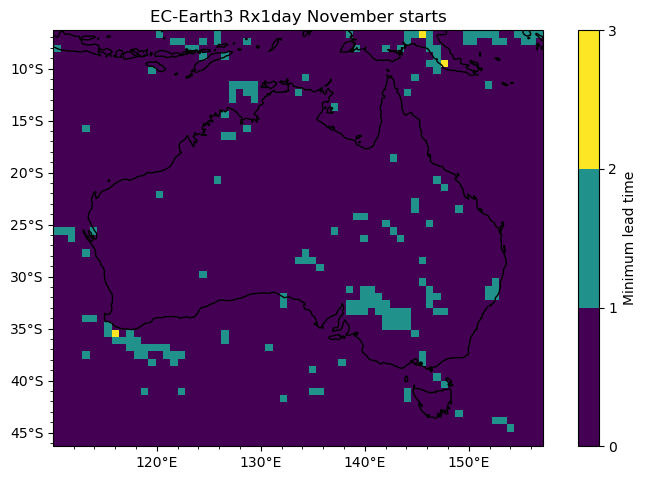

In [14]:
independence.spatial_plot(
    ds_independence,
    dataset_name=f"{model_name} {plot_dict['metric']}",
    outfile=independence_plot,
)

Drop dependent lead times based on the minimum independent lead time (may be grid point specific or a spatially averaged value)

In [15]:
min_lead_ds = fileio.open_dataset(
    independence_file,
    variables="min_lead",
    shapefile=shapefile,
    shape_overlap=shape_overlap,
    spatial_agg=min_lead_spatial_agg,
)
min_lead = min_lead_ds["min_lead"].load()

print(min_lead)

<xarray.DataArray 'min_lead' ()> Size: 8B
array(0.)
Coordinates:
    month    int64 8B 11
Attributes:
    long_name:    Minimum lead time
    description:  First lead within the independence confidence interval


In [16]:
model_ds = model_ds.groupby(f"{init_dim}.month").where(model_ds[lead_dim] >= min_lead)
model_ds = model_ds.dropna(lead_dim, how="all")
model_ds

<xarray.Dataset> Size: 359MB
Dimensions:     (init_date: 58, ensemble: 15, lead_time: 9, lat: 57, lon: 67)
Coordinates:
    event_time  (init_date, ensemble, lead_time, lat, lon) object 239MB 1962-...
  * lon         (lon) float64 536B 110.4 111.1 111.8 112.5 ... 155.4 156.1 156.8
  * lat         (lat) float64 456B -45.97 -45.26 -44.56 ... -8.07 -7.368 -6.667
  * ensemble    (ensemble) int64 120B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * lead_time   (lead_time) int64 72B 0 1 2 3 4 5 6 7 8
  * init_date   (init_date) object 464B 1962-11-01 00:00:00 ... 2019-11-01 00...
    time        (lead_time, init_date) object 4kB dask.array<chunksize=(9, 58), meta=np.ndarray>
    month       int64 8B 11
Data variables:
    pr          (init_date, ensemble, lead_time, lat, lon) float32 120MB dask.array<chunksize=(58, 15, 9, 57, 67), meta=np.ndarray>
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               DCPP
    branch_method:             no parent
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    variant_info:              Atmosphere initialization based on full-fields...
    nominal_resolution:        100 km
    sub_experiment:            initialized near end of year 1960
    sub_experiment_id:         s1960
    history:                   Thu Apr 17 12:44:44 2025: /g/data/xv83/as3189/...
    NCO:                       netCDF Operators version 4.9.2 (Homepage = htt...

In [17]:
if plot_additive_bc:
    model_add_bc_ds = model_add_bc_ds.groupby(f"{init_dim}.month").where(
        model_add_bc_ds[lead_dim] >= min_lead
    )
    model_add_bc_ds = model_add_bc_ds.dropna(lead_dim, how="all")
    model_add_bc_ds

In [18]:
if plot_multiplicative_bc:
    model_mulc_bc_ds = model_mulc_bc_ds.groupby(f"{init_dim}.month").where(
        model_mulc_bc_ds[lead_dim] >= min_lead
    )
    model_mulc_bc_ds = model_mulc_bc_ds.dropna(lead_dim, how="all")
    model_mulc_bc_ds

In [19]:
# Get the model start year after dropping any dependent lead times
start_year = model_ds.time.dt.year.min().load().item()
start_year

1962

## Similarity tests
We can look at p-values for the KS-test and Anderson-Darling test for each lead time.

A p-value greater than alpha indicates the null hypothesis (that the two samples are from the same population) can't be rejected (i.e., blue indicates where the model and obs are NOT significantly different).

We add versions of each plot with stippling over regions where the model data distribution is significantly different from the observations (p<=alpha; specific test based on user input).

In [20]:
print(
    f"The map stippling is based on the {similarity_test} test significance (i.e., stippling where p<={alpha} - indicating where the model is significantly different from the observations)"
)

The map stippling is based on the ks test significance (i.e., stippling where p<=0.05 - indicating where the model is significantly different from the observations)


In [21]:
similarity_ds = fileio.open_dataset(str(similarity_raw_file))
similarity_ds

<xarray.Dataset> Size: 62kB
Dimensions:       (lon: 67, lat: 57)
Coordinates:
  * lon           (lon) float64 536B 110.4 111.1 111.8 ... 155.4 156.1 156.8
  * lat           (lat) float64 456B -45.97 -45.26 -44.56 ... -7.368 -6.667
Data variables:
    ks_statistic  (lat, lon) float32 15kB dask.array<chunksize=(57, 67), meta=np.ndarray>
    ks_pval       (lat, lon) float32 15kB dask.array<chunksize=(57, 67), meta=np.ndarray>
    ad_statistic  (lat, lon) float32 15kB dask.array<chunksize=(57, 67), meta=np.ndarray>
    ad_pval       (lat, lon) float32 15kB dask.array<chunksize=(57, 67), meta=np.ndarray>
Attributes:
    history:  Sun Apr 27 20:12:57 2025: /g/data/xv83/as3189/conda/envs/unseen...

In [22]:
# Add the similarity test results to the dataset for convenience
model_ds["pval_mask"] = similarity_ds[f"{similarity_test}_pval"] <= alpha

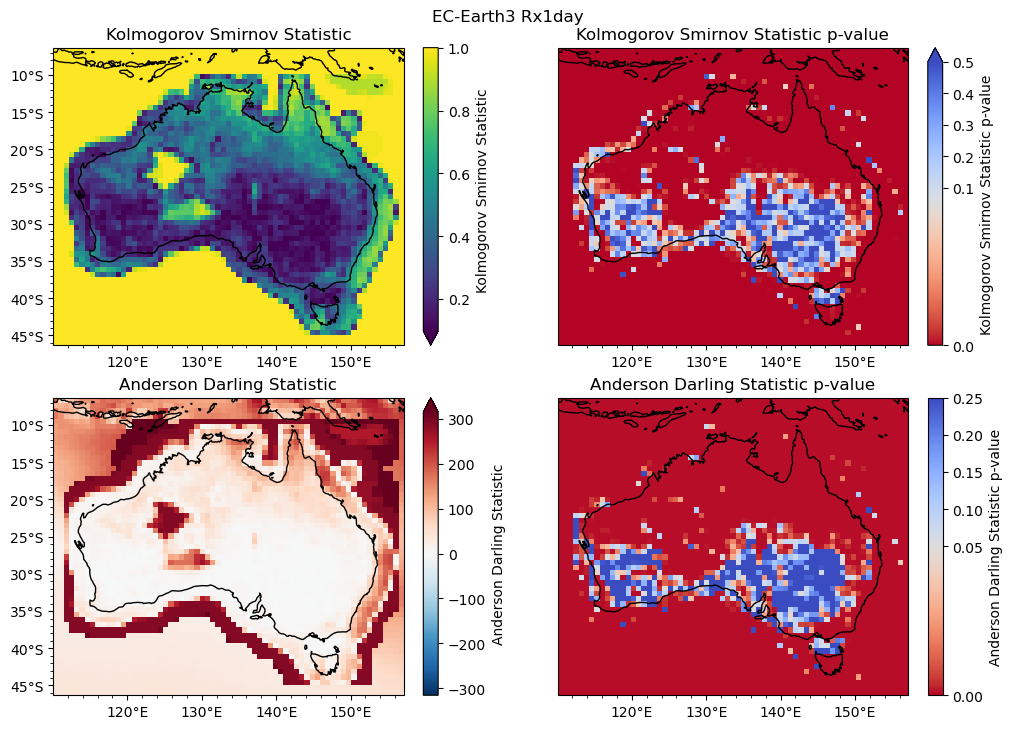

In [23]:
# Note that the colour bars for the KS and AD test p-values are the same, but the AD test p-value maximum is 0.25
similarity.similarity_spatial_plot(
    similarity_ds,
    dataset_name=f"{model_name} {plot_dict['metric']}",
    outfile=similarity_raw_plot,
)

### Additive bias corrected similarity tests

In [24]:
if Path(similarity_add_bc_file).exists():
    similarity_add_bc_ds = fileio.open_dataset(str(similarity_add_bc_file))

In [25]:
if plot_additive_bc:
    # Add the similarity test results to the dataset
    model_add_bc_ds["pval_mask"] = (
        similarity_add_bc_ds[f"{similarity_test}_pval"] <= alpha
    )

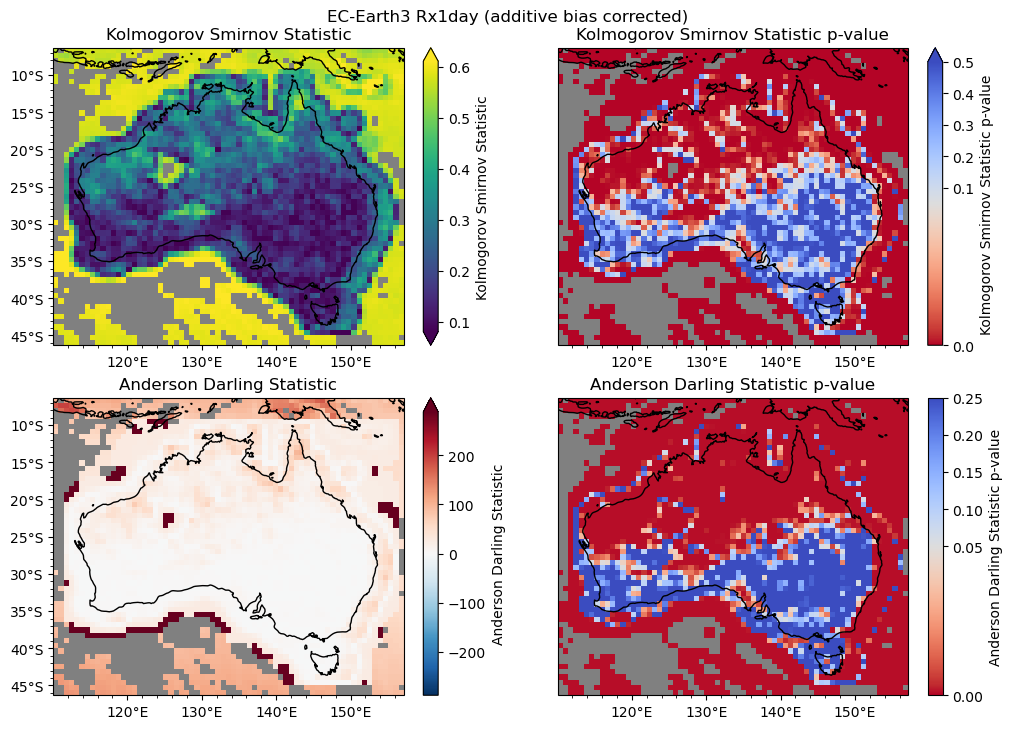

In [26]:
if Path(similarity_add_bc_file).exists():
    # Plot the similarity test results
    similarity.similarity_spatial_plot(
        similarity_add_bc_ds,
        dataset_name=f"{model_name} {plot_dict['metric']} (additive bias corrected)",
        outfile=similarity_add_bc_plot,
    )

### Multiplicative bias corrected similarity test results

In [27]:
if Path(similarity_mulc_bc_file).exists():
    similarity_mulc_bc_ds = fileio.open_dataset(str(similarity_mulc_bc_file))

In [28]:
if plot_multiplicative_bc:
    model_mulc_bc_ds["pval_mask"] = (
        similarity_mulc_bc_ds[f"{similarity_test}_pval"] <= alpha
    )

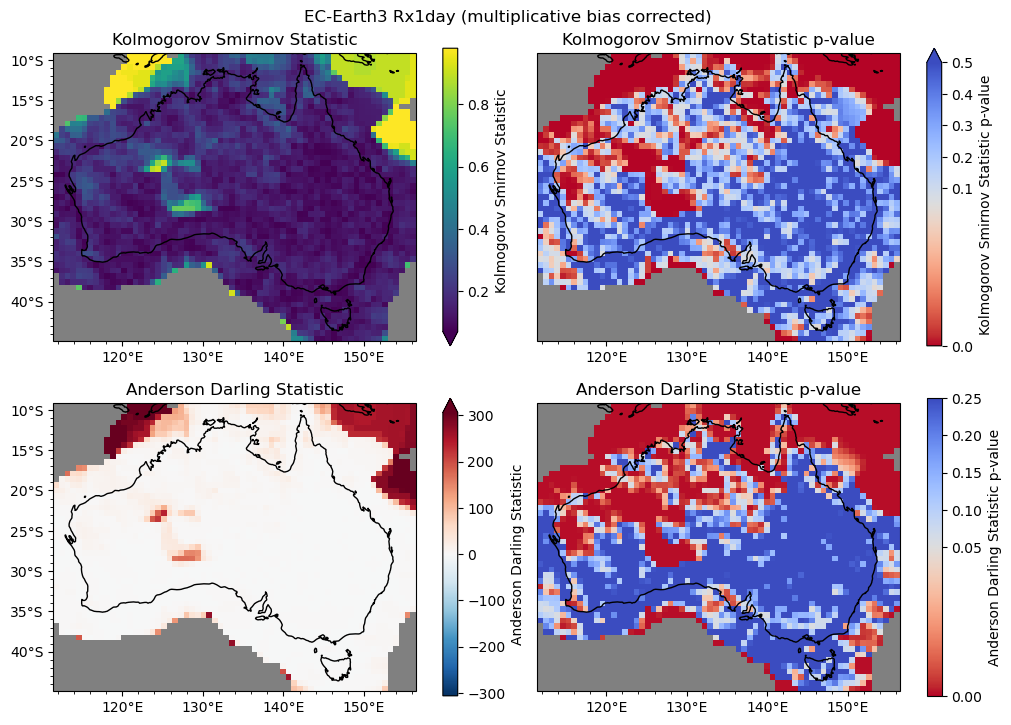

In [29]:
# Plot the similarity test results
if Path(similarity_mulc_bc_file).exists():
    similarity.similarity_spatial_plot(
        similarity_mulc_bc_ds,
        dataset_name=f"{model_name} {plot_dict['metric']} (multiplicative bias corrected)",
        outfile=similarity_mulc_bc_plot,
    )

## Stack dataset dimensions
Combine the ensemble, lead and initialisation time dimensions into a single "sample" dimension. The stacked data will have shape (n_samples, n_lat, n_lon) and will be used for the remaining analysis. 

The dataset is also rechunked into a single array chunk along the sample dimension (avoids multiple chunks along core dimension error when using apply_ufunc with dask='parallelized' with CAFE output).

In [30]:
model_ds_stacked = model_ds.stack(
    {"sample": [ensemble_dim, init_dim, lead_dim]}, create_index=False
)
model_ds_stacked = model_ds_stacked.transpose("sample", ...)
model_ds_stacked = model_ds_stacked.dropna("sample", how="all")
model_ds_stacked = model_ds_stacked.chunk(dict(sample=-1))

model_ds_stacked

<xarray.Dataset> Size: 359MB
Dimensions:     (sample: 7830, lat: 57, lon: 67)
Coordinates:
    event_time  (sample, lat, lon) object 239MB dask.array<chunksize=(7830, 57, 67), meta=np.ndarray>
  * lon         (lon) float64 536B 110.4 111.1 111.8 112.5 ... 155.4 156.1 156.8
  * lat         (lat) float64 456B -45.97 -45.26 -44.56 ... -8.07 -7.368 -6.667
    ensemble    (sample) int64 63kB dask.array<chunksize=(7830,), meta=np.ndarray>
    lead_time   (sample) int64 63kB dask.array<chunksize=(7830,), meta=np.ndarray>
    init_date   (sample) object 63kB dask.array<chunksize=(7830,), meta=np.ndarray>
    time        (sample) object 63kB dask.array<chunksize=(7830,), meta=np.ndarray>
    month       int64 8B 11
Dimensions without coordinates: sample
Data variables:
    pr          (sample, lat, lon) float32 120MB dask.array<chunksize=(7830, 57, 67), meta=np.ndarray>
    pval_mask   (lat, lon) bool 4kB dask.array<chunksize=(57, 67), meta=np.ndarray>
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               DCPP
    branch_method:             no parent
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    variant_info:              Atmosphere initialization based on full-fields...
    nominal_resolution:        100 km
    sub_experiment:            initialized near end of year 1960
    sub_experiment_id:         s1960
    history:                   Thu Apr 17 12:44:44 2025: /g/data/xv83/as3189/...
    NCO:                       netCDF Operators version 4.9.2 (Homepage = htt...

In [31]:
# Stack additive bias corrected data
if plot_additive_bc:
    model_add_bc_ds_stacked = model_add_bc_ds.stack(
        {"sample": [ensemble_dim, init_dim, lead_dim]}, create_index=False
    )
    model_add_bc_ds_stacked = model_add_bc_ds_stacked.transpose("sample", ...)
    model_add_bc_ds_stacked = model_add_bc_ds_stacked.dropna("sample", how="all")
    model_add_bc_ds_stacked = model_add_bc_ds_stacked.chunk(dict(sample=-1))
    assert model_ds_stacked[var].shape == model_add_bc_ds_stacked[var].shape

In [32]:
# Stack multiplicative bias corrected data
if plot_multiplicative_bc:
    model_mulc_bc_ds_stacked = model_mulc_bc_ds.stack(
        {"sample": [ensemble_dim, init_dim, lead_dim]}, create_index=False
    )
    model_mulc_bc_ds_stacked = model_mulc_bc_ds_stacked.transpose("sample", ...)
    model_mulc_bc_ds_stacked = model_mulc_bc_ds_stacked.dropna("sample", how="all")
    model_mulc_bc_ds_stacked = model_mulc_bc_ds_stacked.chunk(dict(sample=-1))
    assert model_ds_stacked[var].shape == model_mulc_bc_ds_stacked[var].shape

Number of samples

In [33]:
n_samples = model_ds_stacked[var].dropna("sample", how="any").sample.size
print(f"Number of samples: {n_samples}")

Number of samples: 7830


## Observational data

In [34]:
# Open the observational dataset
obs_ds = fileio.open_dataset(obs_file)
obs_ds

<xarray.Dataset> Size: 34MB
Dimensions:     (time: 123, lat: 70, lon: 89)
Coordinates:
  * lat         (lat) float64 560B -44.5 -44.0 -43.5 -43.0 ... -11.0 -10.5 -10.0
  * lon         (lon) float64 712B 112.0 112.5 113.0 113.5 ... 155.0 155.5 156.0
  * time        (time) object 984B 1901-09-30 00:00:00 ... 2023-09-30 00:00:00
    event_time  (time, lat, lon) <U10 31MB dask.array<chunksize=(123, 70, 89), meta=np.ndarray>
Data variables:
    pr          (time, lat, lon) float32 3MB dask.array<chunksize=(123, 70, 89), meta=np.ndarray>
Attributes: (12/34)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Fri Mar 14 15:17:30 2025: /g/data/xv83/as3...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...
    regrid_method:                 conservative

Drop observations before model data is available for plots of model-observational anomalies.

A note on model and observational data time periods:

For most model-obs comparisions, we use the same start time for the model and observational data. Therefore, we use the start year that is updated after dropping dependent lead times, which may vary for different models or grid points (unless the minimum lead is based on a spatial aggregate) even if they were initialised in the same year. To maximise the number of available samples, we do not constrain the end of the time period. This means there may be a mismatch in the the last years of model and obs samples. 


Although, we do use the same time periods for models and obs when bias correcting the data: the climatological base period is based on the model initialisation start and end date (defined in the model dataset config file).


There are some exceptions to this. To aid multi-model comparison of the GEV-based analysis, we use the same model start year (i.e., before dropping dependent lead times) and observational end year (for calculating trends) and the same covariate_base base year to be substituted in the non-stationary GEV model (which doesn't necessarily have to match the input data time period).

In [35]:
# Drop observations before model initialisation start year
if reference_time_period is not None:
    obs_ds = time_utils.select_time_period(obs_ds, reference_time_period)
obs_ds = obs_ds.where(obs_ds.time.dt.year >= start_year, drop=True)
obs_ds = obs_ds.dropna("time", how="all")
obs_ds

<xarray.Dataset> Size: 17MB
Dimensions:     (time: 61, lat: 70, lon: 89)
Coordinates:
  * lat         (lat) float64 560B -44.5 -44.0 -43.5 -43.0 ... -11.0 -10.5 -10.0
  * lon         (lon) float64 712B 112.0 112.5 113.0 113.5 ... 155.0 155.5 156.0
  * time        (time) object 488B 1962-09-30 00:00:00 ... 2022-09-30 00:00:00
    event_time  (time, lat, lon) <U10 15MB dask.array<chunksize=(61, 70, 89), meta=np.ndarray>
Data variables:
    pr          (time, lat, lon) float32 2MB dask.array<chunksize=(61, 70, 89), meta=np.ndarray>
Attributes: (12/34)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Fri Mar 14 15:17:30 2025: /g/data/xv83/as3...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...
    regrid_method:                 conservative

Combine plot kwargs

In [36]:
# Store plot related variables using the InfoSet class
info = spatial_plots.InfoSet(
    name=model_name,
    fig_dir=fig_dir,
    file=model_file,
    obs_name=obs_name,
    ds=model_ds,
    obs_ds=obs_ds,
    bias_correction=None,
    **plot_dict,
)

In [37]:
if plot_additive_bc:
    info_add_bc = spatial_plots.InfoSet(
        name=model_name,
        fig_dir=fig_dir,
        file=model_add_bc_file,
        ds=model_add_bc_ds,
        obs_name=obs_name,
        obs_ds=obs_ds,
        bias_correction="additive",
        **plot_dict,
    )

In [38]:
if plot_multiplicative_bc:
    info_mulc_bc = spatial_plots.InfoSet(
        name=model_name,
        fig_dir=fig_dir,
        file=model_mulc_bc_file,
        obs_name=obs_name,
        ds=model_mulc_bc_ds,
        obs_ds=obs_ds,
        bias_correction="multiplicative",
        **plot_dict,
    )

Print the maximum event magnitude, date and location in observational and model data

In [39]:
def print_event_max(dx, name):
    """Print the maximum event magnitude, date and location."""
    dx = dx.compute()
    dx = dx.where(dx == dx.max(), drop=True)
    print(
        f"{name} max event: {dx.item():.2f} {plot_dict['units']}",
        f"on {dx.time.dt.strftime('%Y-%m-%d').item()} at {-1 * dx.lat.item():.2f}°S, {dx.lon.item():.2f}°E",
    )

In [40]:
# Observed data
print_event_max(obs_ds[var], obs_name)

AGCD-CSIRO max event: 718.15 mm day-1 on 2010-09-30 at 13.50°S, 126.00°E


In [41]:
# Model data
print_event_max(model_ds_stacked[var], model_name)
if plot_additive_bc:
    print_event_max(
        model_add_bc_ds_stacked[var], f"{model_name} (additive bias corrected)"
    )
if plot_multiplicative_bc:
    print_event_max(
        model_mulc_bc_ds_stacked[var], f"{model_name} (multiplicative bias corrected)"
    )

## Histograms at each Australian capital city

In [ ]:
# Lat and lon of Australian capital cities
cities = {
    "Canberra": (-35.282, 149.128),
    "Sydney": (-33.8688, 151.2093),
    "Melbourne": (-37.8136, 144.9631),
    "Brisbane": (-27.4698, 153.0251),
    "Perth": (-31.9505, 115.8605),
    "Adelaide": (-34.9285, 138.6007),
    "Hobart": (-42.8821, 147.3272),
    "Darwin": (-12.4634, 130.8456),
}
# Plot histograms of the model and observations at each capital city
fig = plt.figure(figsize=(15, 12))

for i, (city, (lat, lon)) in enumerate(cities.items()):
    ax = fig.add_subplot(3, 3, i + 1)
    obs_ds[var].sel(lat=lat, lon=lon, method="nearest").plot.hist(
        bins=20, alpha=0.6, color="k", label="Observations", ax=ax, density=True
    )
    model_ds_stacked[var].sel(lat=lat, lon=lon, method="nearest").plot.hist(
        bins="auto", alpha=0.3, color="b", label=model_name, ax=ax, density=True
    )
    if plot_additive_bc:
        model_add_bc_ds_stacked[var].sel(lat=lat, lon=lon, method="nearest").plot.hist(
            bins="auto", alpha=0.3, color="g", label="Additive BC", ax=ax, density=True
        )
    if plot_multiplicative_bc:
        model_mulc_bc_ds_stacked[var].sel(lat=lat, lon=lon, method="nearest").plot.hist(
            bins="auto",
            alpha=0.3,
            color="darkorange",
            label="Multiplicative BC",
            ax=ax,
            density=True,
        )
    ax.set_title(f"{city} {info.metric}")
    # Plot y-axis label on the first column
    if i % 3 == 0:
        ax.set_ylabel("Density")
    ax.set_xlabel(f"{plot_dict['var_name']} ({plot_dict['units']})")
    ax.legend(fontsize="small")

# Add model to suptitle
fig.suptitle(model_name)
plt.tight_layout()
plt.savefig(f"{fig_dir}/histograms_aus_capitals_{info.metric.lower()}_{model_name}.png")

### Histograms where the observations and the bias corrected model are significantly different
This is a Australia-specific diagnostic plot to help determine why bias-corrected data may still have failed the similarity test (i.e., does the model have a much longer tail than observations & did this skew the mean bias used to correct the model).
To select a few representative locations where the test failed, we search for the worst performing grid point in each NCRA region. We leave a blank subplot for any NCRA regions where there are no grid points that failed the test.

In [ ]:
def get_region_min_coords(shapes, da):
    """Get the lat and lon with the smallest similarity pvalue in a region."""
    # Create a mask of grid points within the region
    mask = spatial_selection.centre_mask(shapes, da.lon, da.lat, output="2D")
    mask = spatial_selection._squeeze_and_drop_region(mask)
    masked_da = da.where(~np.isnan(mask), drop=True)
    # Find the coords of da.min() in the region
    da_min = masked_da.where((masked_da == masked_da.min()).load(), drop=True)
    # Ensure only 1 grid point is returned
    for coord in ["lat", "lon"]:
        if da_min[coord].size > 1:
            da_min = da_min.isel({coord: 0}).compute()
            da_min = da_min.where(da_min == da_min.min(), drop=True)
    lat, lon = da_min.lat.item(), da_min.lon.item()
    return lat, lon


regions = regions_dict["ncra_regions"]
print(regions)

region_coords = {}
# Iterate through the NCRA regions in the shapefile
for r in list(regions.label):
    # Subset the NCR
    shapes = regions[regions.label == r]

    # Use bias-corrected or un-corrected model similarity test
    if plot_additive_bc:
        similarity_da = similarity_add_bc_ds[f"{similarity_test}_pval"]
    elif plot_multiplicative_bc:
        similarity_da = similarity_mulc_bc_ds[f"{similarity_test}_pval"]
    else:
        similarity_da = similarity_ds[f"{similarity_test}_pval"]

    # Find the grid point with the lowest similarity test p-value in region
    lat, lon = get_region_min_coords(shapes, similarity_da)

    # Add to dict to be plotted if the similarity if the null hypothesis is rejected
    if similarity_da.sel(lat=lat, lon=lon, method="nearest") <= alpha:
        region_coords[r] = (lat, lon)

region_coords

In [ ]:
# Plot histograms locations in each NCRA region where the similarity test null hypothesis is rejected
if plot_additive_bc:
    title_model_name = f"{model_name} (additive bc)"
elif plot_multiplicative_bc:
    title_model_name = f"{model_name} (multiplicative bc)"
else:
    title_model_name = model_name

fig = plt.figure(figsize=(15, 12))
i = 0
for i, region in enumerate(list(regions.label)):
    if region not in region_coords:
        continue
    (lat, lon) = region_coords[region]
    ax = fig.add_subplot(3, 3, i + 1)

    obs_ds[var].sel(lat=lat, lon=lon, method="nearest").plot.hist(
        bins=20, alpha=0.6, color="k", label="Observations", ax=ax, density=True
    )
    model_ds_stacked[var].sel(lat=lat, lon=lon, method="nearest").plot.hist(
        bins="auto", alpha=0.4, color="b", label=model_name, ax=ax, density=True
    )
    if plot_additive_bc:
        model_add_bc_ds_stacked[var].sel(lat=lat, lon=lon, method="nearest").plot.hist(
            bins="auto", alpha=0.4, color="g", label="Additive BC", ax=ax, density=True
        )
    elif plot_multiplicative_bc:
        model_mulc_bc_ds_stacked[var].sel(lat=lat, lon=lon, method="nearest").plot.hist(
            bins="auto",
            alpha=0.4,
            color="darkorange",
            label="Multiplicative BC",
            ax=ax,
            density=True,
        )
    ax.set_title(f"{region} ({lat:.1f}, {lon:.1f})")
    # Plot y-axis label on the first column
    if i % 3 == 0:
        ax.set_ylabel("Density")
    ax.set_xlabel(f"{plot_dict['var_name']} ({plot_dict['units']})")
    ax.legend(fontsize="small")


# Add model to suptitle
fig.suptitle(
    f"{title_model_name} {info.metric}: example locations with significant obs-model differences in each NCRA region"
)
plt.tight_layout()
plt.savefig(f"{fig_dir}/histograms_bad_fit_{info.metric.lower()}_{model_name}.png")


## GEV distribution parameters

The stationary GEV distribution is described by three parameters: shape ($\xi$), location ($\mu$) and scale ($\sigma$) parameters. 

The location parameter is qualitatively similar to the median, the scale parameter to the standard deviation and the shape parameter to the skewness of the distribution.

The non-stationary GEV model allows the location and scale parameters to vary linearly with time $t$ as follows:

$\mu = \mu_0 + \mu_1 \times t$  
$\sigma = \sigma_0 + \sigma_1 \times t$.

The location trend term $\mu_1$ can be useful for understanding trends in the mean, while the scale trend term $\sigma_1$ captures the linear trend in the variability of the data (for example changes in the tail behaviours).

The shape parameter is assumed to be constant over time, as it tends to be sensitive and difficult to estimate accurately (Coles, 2001).

Coles, Stuart. An Introduction to Statistical Modeling of Extreme Values. Springer Series in Statistics, London, Springer London, 2001, [doi.org/10.1007/978-1-4471-3675-0](https://doi.org/10.1007/978-1-4471-3675-0).


For any value of $t$, the model provides a specific location ($\mu$) and scale ($\sigma$) parameters, resulting in a unique probability density function (PDF) and return value. It is important to note that the model estimates the distribution for a specific year based on the overall trends and relationships in the data. That is, the PDF for any given year is optimised to fit the entire dataset, not just the data from a specific year (like linear regression).


Unless otherwise specified (i.e., for spatial_plots.plot_aep and spatial_plots.new_record_probability), the non-stationary GEV is evaluated using the `covariate_base`.

In [ ]:
# Non-stationary covariate (i.e., a variable that co-varies with the target variable)
covariate = model_ds_stacked[time_dim].dt.year
dparams_ns = xr.open_dataset(gev_params_nonstationary_file)[var]
dparams_ns

In [ ]:
# Ensure model ds and GEV parameters have the same lat/lon grid (it is hard to fit a
# GEV at ocean points, so we usually apply a mask that may drop some lat/lons)
model_ds_stacked = model_ds_stacked.sel(lat=dparams_ns.lat, lon=dparams_ns.lon)

In [ ]:
if plot_additive_bc:
    dparams_add_bc_ns = xr.open_dataset(gev_params_nonstationary_add_bc_file)[var]
    model_add_bc_ds_stacked = model_add_bc_ds_stacked.sel(
        lat=dparams_add_bc_ns.lat, lon=dparams_add_bc_ns.lon
    )

In [ ]:
if plot_multiplicative_bc:
    dparams_mulc_bc_ns = xr.open_dataset(gev_params_nonstationary_mulc_bc_file)[var]
    model_mulc_bc_ds_stacked = model_mulc_bc_ds_stacked.sel(
        lat=dparams_mulc_bc_ns.lat, lon=dparams_mulc_bc_ns.lon
    )

### Non-stationary GEV parameters
Diagnostic plot of all time-dependent GEV parameters: shape, location (intercept and trend) and scale (intercept and trend). Note that the stationary parameters (with no trend) will be shown if if nonstationary GEV fit is not significantly better than the stationary fit (depending on the user input).

In [ ]:
eva.spatial_plot_gev_parameters(
    dparams_ns,
    dataset_name=f"{model_name} {plot_dict['metric']}",
    outfile=f"{info.fig_dir}/gev_parameters_{info.filestem()}.png",
)

In [ ]:
if plot_additive_bc:
    eva.spatial_plot_gev_parameters(
        dparams_add_bc_ns,
        dataset_name=f"{model_name} {plot_dict['metric']} (additive bias corrected)",
        outfile=f"{info_add_bc.fig_dir}/gev_parameters_{info_add_bc.filestem()}.png",
    )

In [ ]:
if plot_multiplicative_bc:
    eva.spatial_plot_gev_parameters(
        dparams_mulc_bc_ns,
        dataset_name=f"{model_name} {plot_dict['metric']} (multiplicative bias corrected)",
        outfile=f"{info_mulc_bc.fig_dir}/gev_parameters_{info_mulc_bc.filestem()}.png",
    )

### Stationary GEV parameters

Note that the stationary GEV parameters are not used in the spatial analysis, but are included for completeness. If stationary GEV parameters were run using `assert_good_fit`, then NaN grid points indicate that the stationary GEV fit did not pass the goodness of fit test. 

In [ ]:
if Path(gev_params_stationary_file).exists():
    dparams = xr.open_dataset(gev_params_stationary_file)[var]
    eva.spatial_plot_gev_parameters(
        dparams,
        dataset_name=f"{info.name} {plot_dict['metric']}",
        outfile=f"{info.fig_dir}/gev_parameters_stationary_{info.filestem()}.png",
    )

In [ ]:
if plot_additive_bc and Path(gev_params_stationary_add_bc_file).exists():
    dparams_add_bc = xr.open_dataset(gev_params_stationary_add_bc_file)[var]
    eva.spatial_plot_gev_parameters(
        dparams_add_bc,
        dataset_name=f"{info.name} {plot_dict['metric']} (additive bias corrected)",
        outfile=f"{info_add_bc.fig_dir}/gev_parameters_stationary_{info_add_bc.filestem()}.png",
    )

In [ ]:
if plot_multiplicative_bc and Path(gev_params_stationary_mulc_bc_file).exists():
    dparams_mulc_bc = xr.open_dataset(gev_params_stationary_mulc_bc_file)[var]
    eva.spatial_plot_gev_parameters(
        dparams_mulc_bc,
        dataset_name=f"{info.name} {plot_dict['metric']} (multiplicative bias corrected)",
        outfile=f"{info_mulc_bc.fig_dir}/gev_parameters_stationary_{info_mulc_bc.filestem()}.png",
    )


Diagnostic plot:
 the difference between the nonstationary GEV parameters and the best of stationary/nonstationary GEV parameters (stationary GEV parameters in regions where it is a better fit than the nonstationary parameters). By default, the analysis is based on the nonstationary GEV parameters.

In [ ]:
if Path(gev_params_best_file).exists():
    dparams_best = xr.open_dataset(gev_params_best_file)[var]
    dparams_diff = dparams_ns - dparams_best
    eva.spatial_plot_gev_parameters(
        dparams_diff,
        dataset_name=f"{info.name} (non-stationary - best)",
        outfile=f"{info.fig_dir}/gev_parameters_best_diff_{info.filestem()}.png",
    )

In [ ]:
if plot_additive_bc and Path(gev_params_best_add_bc_file).exists():
    dparams_add_bc_best = xr.open_dataset(gev_params_best_add_bc_file)[var]
    dparams_add_bc_diff = dparams_add_bc_ns - dparams_add_bc_best
    eva.spatial_plot_gev_parameters(
        dparams_add_bc_diff,
        dataset_name=f"{info_add_bc.name} (non-stationary - best)",
        outfile=f"{info.fig_dir}/gev_parameters_best_diff_{info_add_bc.filestem()}.png",
    )

In [ ]:
if plot_multiplicative_bc and Path(gev_params_best_mulc_bc_file).exists():
    dparams_mulc_bc_best = xr.open_dataset(gev_params_best_mulc_bc_file)[var]
    dparams_mulc_bc_diff = dparams_mulc_bc_ns - dparams_mulc_bc_best
    eva.spatial_plot_gev_parameters(
        dparams_mulc_bc_diff,
        dataset_name=f"{info_mulc_bc.name} (non-stationary - best)",
        outfile=f"{info.fig_dir}/gev_parameters_best_diff_{info_mulc_bc.filestem()}.png",
    )

### GEV location trend parameter

In [ ]:
spatial_plots.plot_gev_param_trend(
    info, dparams_ns, param="location", mask=model_ds_stacked.pval_mask
)

In [ ]:
# Additive bias corrected
if plot_additive_bc:
    spatial_plots.plot_gev_param_trend(
        info_add_bc,
        dparams_add_bc_ns,
        param="location",
        mask=model_add_bc_ds_stacked.pval_mask,
    )

In [ ]:
# Multiplicative bias corrected
if plot_multiplicative_bc:
    spatial_plots.plot_gev_param_trend(
        info_mulc_bc,
        dparams_mulc_bc_ns,
        param="location",
        mask=model_mulc_bc_ds_stacked.pval_mask,
    )

### GEV scale trend parameter

In [ ]:
spatial_plots.plot_gev_param_trend(
    info, dparams_ns, param="scale", mask=model_ds_stacked.pval_mask
)

In [ ]:
# Bias corrected data
if plot_additive_bc:
    spatial_plots.plot_gev_param_trend(
        info_add_bc,
        dparams_add_bc_ns,
        param="scale",
        mask=model_add_bc_ds_stacked.pval_mask,
    )

In [ ]:
if plot_multiplicative_bc:
    spatial_plots.plot_gev_param_trend(
        info_mulc_bc,
        dparams_mulc_bc_ns,
        param="scale",
        mask=model_mulc_bc_ds_stacked.pval_mask,
    )

## Year of record event
Plot the year when the record event occurred for each grid point. 

Lighter colours indicate when more recent record events occurred. We generally expect the year of the record event to be random. If there is a trend in the record event year, it may indicate a trend in the data. 

In [ ]:
spatial_plots.plot_event_year(info, model_ds_stacked, time_agg)

In [ ]:
if plot_additive_bc:
    spatial_plots.plot_event_year(info_add_bc, model_add_bc_ds_stacked, time_agg)

In [ ]:
if plot_multiplicative_bc:
    spatial_plots.plot_event_year(info_mulc_bc, model_mulc_bc_ds_stacked, time_agg)

## Most common month when event occurs
Plot of the most common month when the event occurred for each grid point. 

While the most common month is shown, there may be other months when events when events commonly occur.

In [ ]:
spatial_plots.plot_event_month_mode(info, model_ds_stacked, mask=None)

In [ ]:
# Additive bias corrected
if plot_additive_bc:
    spatial_plots.plot_event_month_mode(info_add_bc, model_add_bc_ds_stacked, mask=None)

In [ ]:
# Multiplicative bias corrected
if plot_multiplicative_bc:
    spatial_plots.plot_event_month_mode(
        info_mulc_bc, model_mulc_bc_ds_stacked, mask=None
    )


## Median events
Plot the median value of the metric for each grid point

In [ ]:
spatial_plots.plot_time_agg(
    info, model_ds_stacked, "median", mask=model_ds_stacked.pval_mask
)

In [ ]:
# Additive bias corrected
if plot_additive_bc:
    spatial_plots.plot_time_agg(
        info_add_bc,
        model_add_bc_ds_stacked,
        "median",
        mask=model_add_bc_ds_stacked.pval_mask,
    )

In [ ]:
# Multiplicative bias corrected
if plot_multiplicative_bc:
    spatial_plots.plot_time_agg(
        info_mulc_bc,
        model_mulc_bc_ds_stacked,
        "median",
        mask=model_mulc_bc_ds_stacked.pval_mask,
    )

### Model minus observations (median anomaly)
Plot the difference between the model and observational median 

In [ ]:
spatial_plots.plot_obs_anom(
    info, model_ds_stacked, obs_ds, "median", "anom", mask=model_ds_stacked.pval_mask
)

In [ ]:
# Additive bias corrected
if plot_additive_bc:
    spatial_plots.plot_obs_anom(
        info_add_bc,
        model_add_bc_ds_stacked,
        obs_ds,
        "median",
        "anom",
        mask=model_add_bc_ds_stacked.pval_mask,
    )

In [ ]:
# Multiplicative bias corrected
if plot_multiplicative_bc:
    spatial_plots.plot_obs_anom(
        info_mulc_bc,
        model_mulc_bc_ds_stacked,
        obs_ds,
        "median",
        "anom",
        mask=model_mulc_bc_ds_stacked.pval_mask,
    )

# Most extreme events
Plot the maximum or minimum value of the metric for each grid point

In [ ]:
spatial_plots.plot_time_agg(
    info, model_ds_stacked, time_agg, mask=model_ds_stacked.pval_mask
)

In [ ]:
# Additive bias corrected
if plot_additive_bc:
    spatial_plots.plot_time_agg(
        info_add_bc,
        model_add_bc_ds_stacked,
        time_agg,
        mask=model_add_bc_ds_stacked.pval_mask,
    )

In [ ]:
# Multiplicative bias corrected
if plot_multiplicative_bc:
    spatial_plots.plot_time_agg(
        info_mulc_bc,
        model_mulc_bc_ds_stacked,
        time_agg,
        mask=model_mulc_bc_ds_stacked.pval_mask,
    )

## Model and observation record event difference

Plot the difference between the model and observed record event using the following metrics:
- absolute differenc (model - obs)
- anomaly percentage (model - obs / obs)
- standardised anomaly (model - obs / obs standard deviation)
- ratio of the theoretical maximum to the observed maximum (Model GEV-estimated 2000 year return level / obs)

Note that the metric in observations is conservatively regridded to the coarser model grid in order to plot the difference.

In [ ]:
anom_metrics = ["anom", "anom_pct", "anom_std", "anom_2000yr"]

In [ ]:
for anom_metric in anom_metrics:
    spatial_plots.plot_obs_anom(
        info,
        model_ds_stacked,
        obs_ds,
        time_agg,
        anom_metric,
        dparams_ns=dparams_ns,
        covariate_base=covariate_base,
        mask=model_ds_stacked.pval_mask,
    )

In [ ]:
# Additive bias corrected
if plot_additive_bc:
    for anom_metric in anom_metrics:
        spatial_plots.plot_obs_anom(
            info_add_bc,
            model_add_bc_ds_stacked,
            obs_ds,
            time_agg,
            anom_metric,
            dparams_ns=dparams_add_bc_ns,
            covariate_base=covariate_base,
            mask=model_add_bc_ds_stacked.pval_mask,
        )

In [ ]:
# Multiplicative bias corrected
if plot_multiplicative_bc:
    for anom_metric in anom_metrics:
        spatial_plots.plot_obs_anom(
            info_mulc_bc,
            model_mulc_bc_ds_stacked,
            obs_ds,
            time_agg,
            anom_metric,
            dparams_ns=dparams_mulc_bc_ns,
            covariate_base=covariate_base,
            mask=model_mulc_bc_ds_stacked.pval_mask,
        )

# Subsampling analysis
Here we assess how similar the model data is to the observations with comparable sample sizes. We randomly subsample the model data to match the number of observations and calculate the maximum/minimum values of the metric for each subsample. We repeat this process 1000 times and plot the median of the maximum/minimum values. Note that the subsampling function will plot the masked and unmasked versions of the plot (to avoid re-calculating the subsample, which is quite slow).

First we'll plot the observed maximum/minimum values for comparison.

In [ ]:
# Plot the metric based on observations
info_obs = spatial_plots.InfoSet(
    name=info.obs_name,
    obs_name=info.obs_name,
    fig_dir=fig_dir,
    file=obs_file,
    ds=obs_ds,
    bias_correction=None,
    **plot_dict,
)
spatial_plots.plot_time_agg(info_obs, obs_ds, time_agg, savefig=False)

In [ ]:
spatial_plots.plot_time_agg_subsampled(
    info, model_ds_stacked, obs_ds, time_agg, resamples=1000
)

In [ ]:
# Additive bias corrected
if plot_additive_bc:
    spatial_plots.plot_time_agg_subsampled(
        info_add_bc,
        model_add_bc_ds_stacked,
        obs_ds,
        time_agg,
        resamples=1000,
    )

In [ ]:
# Multiplicative bias corrected
if plot_multiplicative_bc:
    spatial_plots.plot_time_agg_subsampled(
        info_mulc_bc,
        model_mulc_bc_ds_stacked,
        obs_ds,
        time_agg,
        resamples=1000,
    )

## Annual exceedance probability
### Empirical annual exceedance probability
Plot the empirical annual exceedance probability for different thresholds

In [ ]:
# ARI: 10, 100, 1000 years (i.e., 10% AEP is equiv to a 1-in-10-year event)
aep = 1

### Empirical 1% AEP (1-in-100-year event)

In [ ]:
spatial_plots.plot_aep_empirical(
    info,
    model_ds_stacked,
    aep=aep,
    mask=model_ds_stacked.pval_mask,
)

In [ ]:
# Additive bias corrected
if plot_additive_bc:
    spatial_plots.plot_aep_empirical(
        info_add_bc,
        model_add_bc_ds_stacked,
        aep=aep,
        mask=model_add_bc_ds_stacked.pval_mask,
    )

In [ ]:
# Multiplicative bias corrected
if plot_multiplicative_bc:
    spatial_plots.plot_aep_empirical(
        info_mulc_bc,
        model_mulc_bc_ds_stacked,
        aep=aep,
        mask=model_mulc_bc_ds_stacked.pval_mask,
    )

### GEV-based annual exceedance probability
Plot the GEV-based annual exceedance probability for different thresholds.

In [ ]:
# this is the start and end year we use generate trends in the AEP
times = xr.DataArray(gev_trend_period, dims=info.time_dim)

### 1% AEP (1-in-100-year event) using the non-stationary GEV (past year, current year and the change per decade)

In [ ]:
spatial_plots.plot_aep(
    info,
    dparams_ns,
    times,
    aep=aep,
    mask=model_ds_stacked.pval_mask,
)

In [ ]:
# Additive bias corrected
if plot_additive_bc:
    spatial_plots.plot_aep(
        info_add_bc,
        dparams_add_bc_ns,
        times,
        aep=aep,
        mask=model_add_bc_ds_stacked.pval_mask,
    )

In [ ]:
# Multiplicative bias corrected
if plot_multiplicative_bc:
    spatial_plots.plot_aep(
        info_mulc_bc,
        dparams_mulc_bc_ns,
        times,
        aep=aep,
        mask=model_mulc_bc_ds_stacked.pval_mask,
    )

## Annual reccurence of observed max/min event

### Empirical return period
Plot the empirical return period for the observed maximum or minimum event

In [ ]:
spatial_plots.plot_obs_ari_empirical(
    info,
    obs_ds,
    model_ds_stacked,
    time_agg=time_agg,
    mask=model_ds_stacked.pval_mask,
)

In [ ]:
# Additive bias corrected
if plot_additive_bc:
    spatial_plots.plot_obs_ari_empirical(
        info_add_bc,
        obs_ds,
        model_add_bc_ds_stacked,
        time_agg=time_agg,
        mask=model_add_bc_ds_stacked.pval_mask,
    )

In [ ]:
# Multiplicative bias corrected
if plot_multiplicative_bc:
    spatial_plots.plot_obs_ari_empirical(
        info_mulc_bc,
        obs_ds,
        model_mulc_bc_ds_stacked,
        time_agg=time_agg,
        mask=model_mulc_bc_ds_stacked.pval_mask,
    )

### GEV-based return period
Plot the GEV-based return period for the observed maximum or minimum event

In [ ]:
spatial_plots.plot_obs_ari(
    info,
    obs_ds,
    model_ds_stacked,
    dparams_ns,
    covariate_base,
    time_agg=time_agg,
    mask=model_ds_stacked.pval_mask,
)

In [ ]:
# Additive bias corrected
if plot_additive_bc:
    spatial_plots.plot_obs_ari(
        info_add_bc,
        obs_ds,
        model_add_bc_ds_stacked,
        dparams_add_bc_ns,
        covariate_base,
        time_agg=time_agg,
        mask=model_add_bc_ds_stacked.pval_mask,
    )

In [ ]:
# Multiplicative bias corrected
if plot_multiplicative_bc:
    spatial_plots.plot_obs_ari(
        info_mulc_bc,
        obs_ds,
        model_mulc_bc_ds_stacked,
        dparams_mulc_bc_ns,
        covariate_base,
        time_agg=time_agg,
        mask=model_mulc_bc_ds_stacked.pval_mask,
    )

# Probability of breaking the observed record
Plot the probability of breaking the observed record in the next 10 years.

### Empirical-based probability of breaking the record

In [ ]:
spatial_plots.plot_new_record_probability_empirical(
    info,
    obs_ds,
    model_ds_stacked,
    time_agg,
    n_years=10,
    mask=model_ds_stacked.pval_mask,
)

In [ ]:
# Additive bias corrected
if plot_additive_bc:
    spatial_plots.plot_new_record_probability_empirical(
        info_add_bc,
        obs_ds,
        model_add_bc_ds_stacked,
        time_agg,
        n_years=10,
        mask=model_add_bc_ds_stacked.pval_mask,
    )

In [ ]:
# Multiplicative bias corrected
if plot_multiplicative_bc:
    spatial_plots.plot_new_record_probability_empirical(
        info_mulc_bc,
        obs_ds,
        model_mulc_bc_ds_stacked,
        time_agg,
        n_years=10,
        mask=model_mulc_bc_ds_stacked.pval_mask,
    )

### GEV-based probability of breaking the observed record

In [ ]:
spatial_plots.plot_new_record_probability(
    info,
    obs_ds,
    model_ds_stacked,
    dparams_ns,
    covariate_base,
    time_agg,
    n_years=10,
    mask=model_ds_stacked.pval_mask,
)

In [ ]:
# Additive bias corrected
if plot_additive_bc:
    spatial_plots.plot_new_record_probability(
        info_add_bc,
        obs_ds,
        model_add_bc_ds_stacked,
        dparams_add_bc_ns,
        covariate_base,
        time_agg,
        n_years=10,
        mask=model_add_bc_ds_stacked.pval_mask,
    )

In [ ]:
# Multiplicative bias corrected
if plot_multiplicative_bc:
    spatial_plots.plot_new_record_probability(
        info_mulc_bc,
        obs_ds,
        model_mulc_bc_ds_stacked,
        dparams_mulc_bc_ns,
        covariate_base,
        time_agg,
        n_years=10,
        mask=model_mulc_bc_ds_stacked.pval_mask,
    )